In [28]:
from src.final_product import PlantForecast
import src.cross_validation as cv
import src.modis_preprocessing as mpre
import src.graphing_tools as gtools

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import os
import time
import gdal

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})


## Initiate the class PlantForecast()

```python
pf = PlantForecast()

pf.load_metadata()

pf.load_ndvi(preloaded=True)

pf.load_weather(preloaded=True)

pf.merge_modis_weather(longterm=365)
```

In [19]:
pf = PlantForecast()

In [20]:
pf.load_metadata()
pf.load_ndvi(preloaded=True)
pf.load_weather(preloaded=True)
pf.merge_modis_weather(longterm=365)

Preloading from path: preloaded_data/2000_2017_ndvi.csv
Preloading from path: preloaded_data/2000_2017_weather.csv
You are lagging for 365 days


## pf.idfinder['station_code'] 
-A handy dictionary tool where you can pass in a station code and get an array with [lat,long,elevation,state], so you don't get too lost ;)

In [21]:
pf.idfinder['AEM00041217']

array([24.433, 54.651, 26.8, 'ABU'], dtype=object)

## Train/Test Split
You can change what years you want to train/test split on. 

In [22]:
train_df, test_df=pf.train_test_split_by_year(test_years=[2015,2016,2017],train_years=list(range(2000,2015)))

In [23]:
X_train= train_df[['PRCP','SNOW','SNOWD','TMAX','TMIN','LT_precip','LT_snow','LT_snowd', 'LT_tmax','LT_tmin','intercept']]
y_train = train_df[['NDVI']].values.reshape(-1,)

In [24]:
X_test= test_df[['PRCP','SNOW','SNOWD','TMAX','TMIN','LT_precip','LT_snow','LT_snowd', 'LT_tmax','LT_tmin','intercept']]
y_test = test_df[['NDVI']].values.reshape(-1,)

Fitting Gradient Boosted Model
Fitting Random Forest Model
Fitting Linear Regression Model
Fitting Ridge Regression Model
Fitting Lasso Regression Model


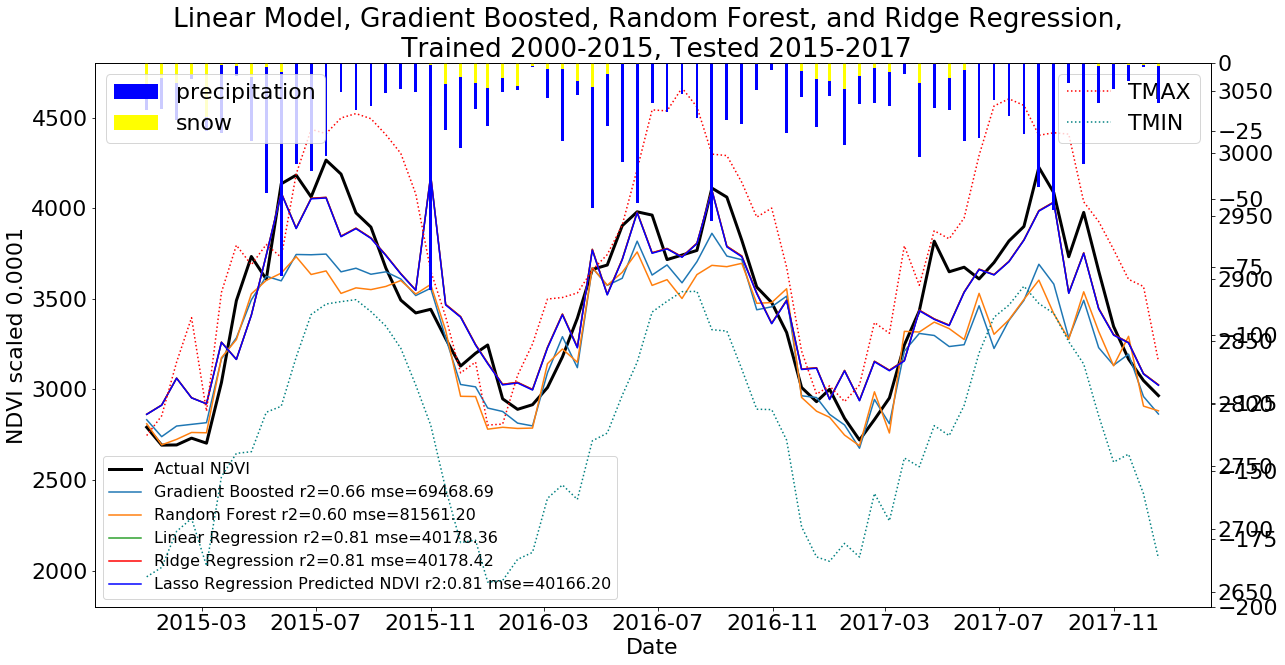

In [32]:
gtools.plot_over_time(X_train, X_test, y_train, y_test)

In [27]:
range_list, gbr_mse_list, rf_mse_list, ridge_mse_list, gbr_score_list, rf_score_list, ridge_score_list=cv.test_for_longterm_mean(450)

Preloading from path: preloaded_data/2000_2017_ndvi.csv
Preloading from path: preloaded_data/2000_2017_weather.csv
Checked average for 1 days in 4.06 seconds with score 0.58, and mse: 86698.30
Checked average for 11 days in 3.88 seconds with score 0.57, and mse: 88965.84
Checked average for 21 days in 3.71 seconds with score 0.60, and mse: 81971.00
Checked average for 31 days in 3.96 seconds with score 0.64, and mse: 73629.30
Checked average for 41 days in 4.61 seconds with score 0.66, and mse: 69458.32
Checked average for 51 days in 4.96 seconds with score 0.68, and mse: 65413.90
Checked average for 61 days in 4.69 seconds with score 0.70, and mse: 61437.31
Checked average for 71 days in 4.13 seconds with score 0.73, and mse: 55488.31
Checked average for 81 days in 3.92 seconds with score 0.74, and mse: 53480.52
Checked average for 91 days in 4.04 seconds with score 0.75, and mse: 52249.89
Checked average for 101 days in 3.96 seconds with score 0.76, and mse: 49030.71
Checked average 

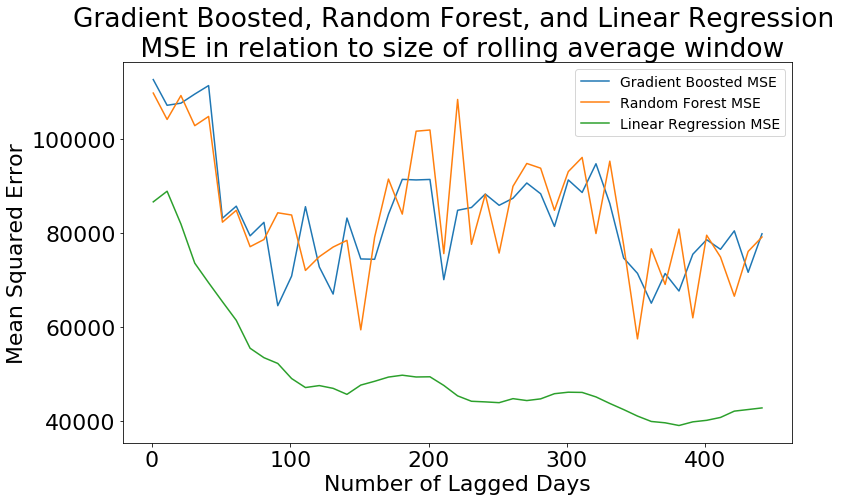

In [31]:
gtools.graph_lag_mse(range_list, gbr_mse_list, rf_mse_list, ridge_mse_list, 
                     gbr_score_list, rf_score_list, ridge_score_list)